# PCA for Face Recognition (Eigenfaces) — From Scratch

This notebook is a unified tutorial inspired by:

- Mathematics for Machine Learning PCA tutorial & solution (mml-book.github.io)
- GeeksforGeeks: *ML | Face Recognition Using PCA Implementation*

We will:

1. Implement PCA **from scratch** on simple data.
2. Extend this implementation to **Eigenfaces-based face recognition** using a real face dataset.
3. Compare:
   - SVM classifier on **original** high-dimensional face data,
   - SVM classifier on **PCA-reduced** data preserving **90%** of variance.

> Work in order, fill in all `TODO` sections, and run cells as you go.


## Learning objectives

After completing this tutorial, you should be able to:

- Explain the geometric idea behind PCA.
- Implement PCA from scratch (centering, covariance, eigendecomposition, projection, reconstruction).
- Apply PCA to high-dimensional face images (Eigenfaces).
- Use PCA as a preprocessing step for classification.
- Compare SVM performance:
  - in full pixel space,
  - in PCA space with 90% variance preserved.


In [1]:
# PACKAGE: DO NOT EDIT THIS CELL
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['image.cmap'] = 'gray'


## 1. PCA on a Simple 2D Dataset

We start with a 2D toy dataset to build intuition:

1. Center the data.
2. Compute the covariance matrix.
3. Compute eigenvalues and eigenvectors.
4. Sort them by explained variance.
5. Project data to 1D and reconstruct.

You will implement helper functions; they will be reused later for faces.


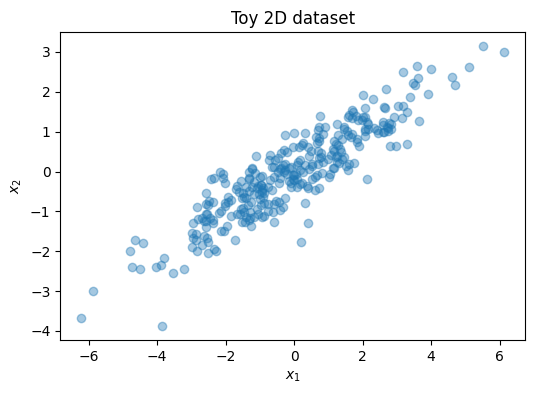

In [2]:
# Create a simple correlated 2D dataset (example)
rng = np.random.default_rng(0)
N = 300
x1 = rng.normal(loc=0.0, scale=2.0, size=N)
x2 = 0.5 * x1 + rng.normal(loc=0.0, scale=0.5, size=N)
X_2d = np.vstack([x1, x2]).T  # shape (N, 2)

plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.4)
plt.title("Toy 2D dataset")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()


In [3]:
def center_data(X: np.ndarray):
    """Center data matrix X by subtracting the mean of each feature.

    Args:
        X: array of shape (n_samples, n_features)

    Returns:
        X_centered: centered data
        mean: feature-wise mean, shape (n_features,)
    """
    mean = np.mean(X, axis=0)
    X_centered = X - mean
    return X_centered, mean

In [4]:
def covariance_matrix(X_centered: np.ndarray):
    """Compute sample covariance matrix for centered data.

    Args:
        X_centered: array of shape (n_samples, n_features)

    Returns:
        Sigma: covariance matrix of shape (n_features, n_features)
    """
    N = X_centered.shape[0]
    Sigma = np.dot(X_centered.T, X_centered) / (N - 1)
    return Sigma

In [5]:
def pca_fit(X: np.ndarray):
    """Fit PCA using eigendecomposition of the covariance matrix.

    Args:
        X: array of shape (n_samples, n_features)

    Returns:
        mean: feature-wise mean, shape (n_features,)
        components: matrix of principal directions (eigenvectors),
                    shape (n_components, n_features)
        eigenvalues: eigenvalues sorted in descending order, shape (n_components,)
    """
    # Hints:
    # 1. Center data using center_data.
    X_centered, mean = center_data(X)

    # 2. Compute covariance matrix.
    Sigma = covariance_matrix(X_centered)

    # 3. Compute eigenvalues and eigenvectors with np.linalg.eigh.
    eigenvalues, eigenvectors = np.linalg.eigh(Sigma)

    # 4. Sort by eigenvalue (descending).
    sorted_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]
    components = eigenvectors.T

    # 5. Return all components (you can slice later).
    return mean, components, eigenvalues

In [6]:
def pca_transform(X: np.ndarray, mean: np.ndarray, components: np.ndarray, n_components: int):
    """Project X onto first n_components principal components.

    Args:
        X: array (n_samples, n_features)
        mean: array (n_features,)
        components: array (n_components_total, n_features)
        n_components: number of components to keep

    Returns:
        Z: projected data, shape (n_samples, n_components)
    """
    X_centered = X - mean
    components_subset = components[:n_components]
    Z = np.dot(X_centered, components_subset.T)
    return Z

def pca_inverse_transform(Z: np.ndarray, mean: np.ndarray, components: np.ndarray, n_components: int):
    """Reconstruct data from PCA representation.

    Args:
        Z: projected data (n_samples, n_components)
        mean: array (n_features,)
        components: array (n_components_total, n_features)
        n_components: number of components used for projection

    Returns:
        X_recon: reconstructed data, shape (n_samples, n_features)
    """
    components_subset = components[:n_components]
    X_recon = np.dot(Z, components_subset) + mean
    return X_recon

Mean: [-0.07163384 -0.04062145]
Eigenvalues: [5.29058849 0.18712638]


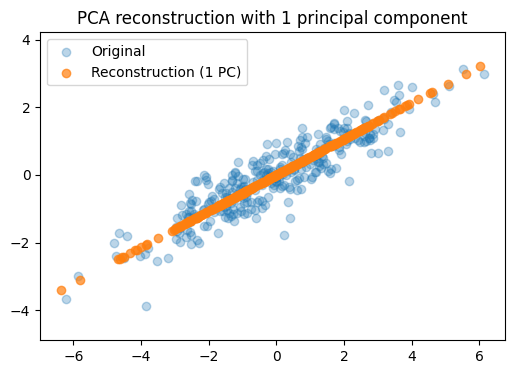

In [7]:
# TEST: run PCA on the toy dataset (after implementing the functions)
mean_2d, comps_2d, vals_2d = pca_fit(X_2d)
print("Mean:", mean_2d)
print("Eigenvalues:", vals_2d)

Z_1d = pca_transform(X_2d, mean_2d, comps_2d, n_components=1)
X_2d_recon = pca_inverse_transform(Z_1d, mean_2d, comps_2d, n_components=1)

plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.3, label="Original")
plt.scatter(X_2d_recon[:, 0], X_2d_recon[:, 1], alpha=0.7, label="Reconstruction (1 PC)")
plt.axis('equal')
plt.legend()
plt.title("PCA reconstruction with 1 principal component")
plt.show()

## 2. PCA for Face Images (Eigenfaces)

Now we move to a real high-dimensional dataset.

We will:

1. Load a labeled face dataset.
2. Flatten each face image into a vector.
3. Use our **from-scratch PCA** to compute Eigenfaces.
4. Visualize leading Eigenfaces.
5. Use PCA features together with SVM for face recognition.


In [8]:
# Load LFW people dataset (downloads if not already present)
lfw = fetch_lfw_people(min_faces_per_person=50, resize=0.4, color=False)
X_faces = lfw.data  # shape (n_samples, n_features)
y_faces = lfw.target
target_names = lfw.target_names
h, w = lfw.images.shape[1:]

print("Faces shape:", X_faces.shape)
print("Image size: {}x{}".format(h, w))
print("Number of classes:", len(target_names))

Faces shape: (1560, 1850)
Image size: 50x37
Number of classes: 12


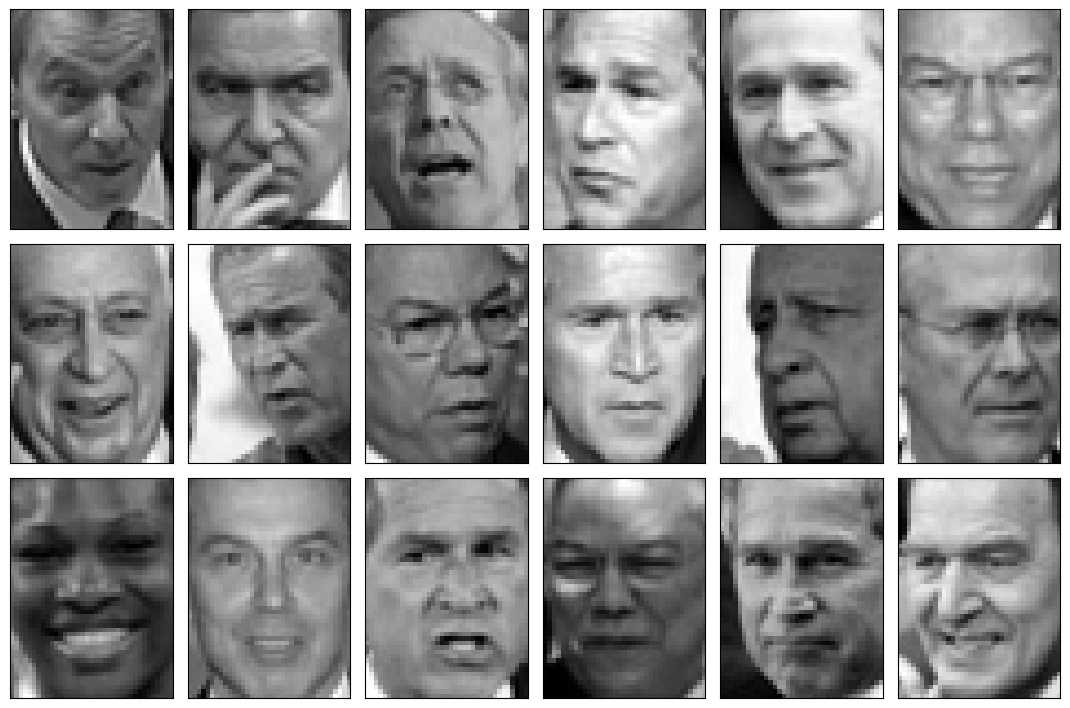

In [9]:
# Visualize a few example faces
def plot_faces(images, titles=None, h=0, w=0, n_row=3, n_col=6):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    for i in range(n_row * n_col):
        if i >= images.shape[0]:
            break
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap='gray')
        plt.xticks(())
        plt.yticks(())
        if titles is not None:
            plt.title(titles[i], fontsize=8)
    plt.tight_layout()
    plt.show()

plot_faces(lfw.images, n_row=3, n_col=6, h=h, w=w)


In [10]:
# Fit PCA (from scratch) to the face dataset for Eigenfaces visualization
# 1. Use your pca_fit on X_faces
mean_faces, components_faces, eigenvalues_faces = pca_fit(X_faces)

# 2. Store mean_faces, components_faces, eigenvalues_faces
print(f"Components shape: {components_faces.shape}")


Components shape: (1850, 1850)


Number of components for 90% variance: 89


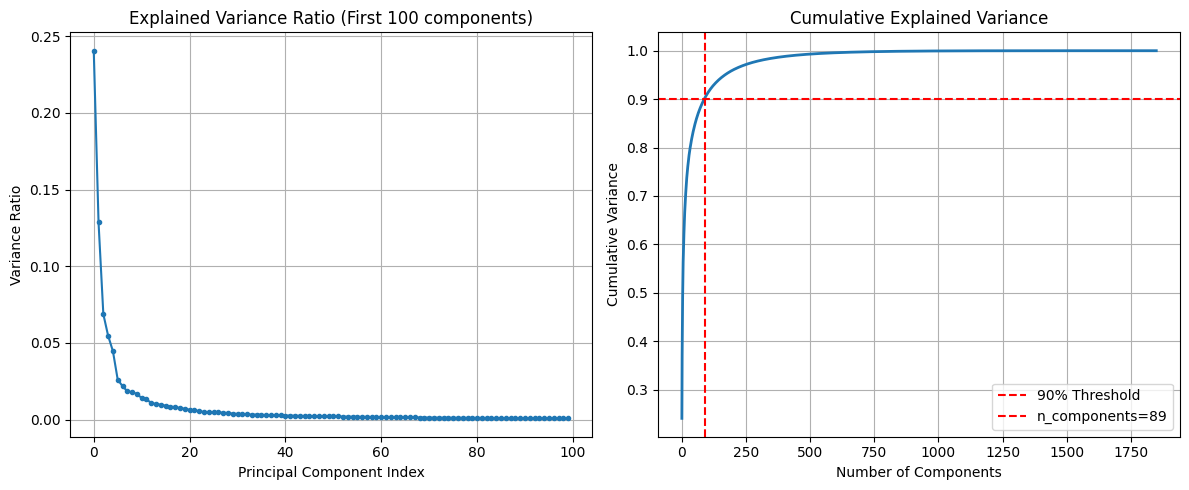

In [11]:
# TODO: Plot explained variance and cumulative explained variance vs number of components
# After you have eigenvalues_faces:
# 1. Compute explained_var_ratio = eigenvalues_faces / eigenvalues_faces.sum()
explained_var_ratio = eigenvalues_faces / np.sum(eigenvalues_faces)

# 2. Compute cumulative_var = np.cumsum(explained_var_ratio)
cumulative_var = np.cumsum(explained_var_ratio)

# 3. Plot:
#    - explained_var_ratio
#    - cumulative_var
# Find k for 90% variance (useful info)
k_90 = np.argmax(cumulative_var >= 0.90) + 1
print(f"Number of components for 90% variance: {k_90}")

# 3. Plot
plt.figure(figsize=(12, 5))

# Plot individual explained variance (Scree Plot) - first 100 components
plt.subplot(1, 2, 1)
plt.plot(explained_var_ratio[:100], marker='.')
plt.title("Explained Variance Ratio (First 100 components)")
plt.xlabel("Principal Component Index")
plt.ylabel("Variance Ratio")
plt.grid(True)

# Plot cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(cumulative_var, linewidth=2)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Threshold')
plt.axvline(x=k_90, color='r', linestyle='--', label=f'n_components={k_90}')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


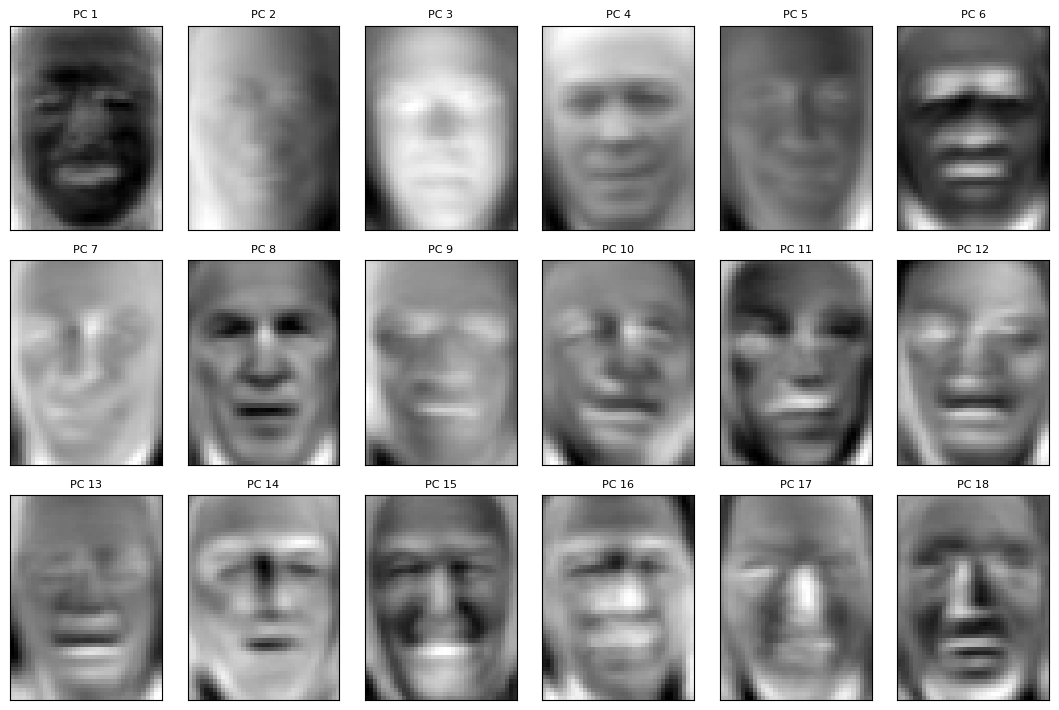

In [12]:
# After implementing PCA above, visualize the leading Eigenfaces

def plot_eigenfaces(components, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    for i in range(n_row * n_col):
        if i >= components.shape[0]:
            break
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(components[i].reshape((h, w)), cmap='gray')
        plt.xticks(())
        plt.yticks(())
        plt.title(f"PC {i+1}", fontsize=8)
    plt.tight_layout()
    plt.show()

# Uncomment when components_faces is defined
plot_eigenfaces(components_faces[:36], h, w)


## 3. Face Recognition with SVM: Full Space vs PCA Space

We now build two SVM-based classifiers:

1. **SVM (full space)**: Train SVM directly on original pixel vectors.
2. **SVM (PCA space)**:
   - Fit PCA **on training data only** using your implementation.
   - Choose the smallest number of components that preserve at least **90%** of total variance.
   - Train SVM on PCA features (train and test projected to this space).

Then we compare accuracies.


In [13]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_faces, y_faces, test_size=0.25, random_state=42, stratify=y_faces
)
print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (1170, 1850)  Test: (390, 1850)


In [14]:
# TODO: Train an SVM classifier on FULL data (no PCA) and evaluate accuracy.

# Suggested baseline:
svm_full = SVC(kernel="linear", class_weight="balanced", random_state=42)
svm_full.fit(X_train, y_train)
y_pred_full = svm_full.predict(X_test)
acc_full = accuracy_score(y_test, y_pred_full)
print(f"SVM (full space) accuracy: {acc_full:.3f}")


SVM (full space) accuracy: 0.815


In [17]:
# TODO: PCA on training data + SVM in PCA space with 90% variance preserved.

# Steps:
# 1. Fit PCA on X_train using pca_fit -> mean_train, comps_train, vals_train.
mean_train, comps_train, vals_train = pca_fit(X_train)

# 2. Compute explained_var_ratio from vals_train.
explained_var_ratio = vals_train / np.sum(vals_train)
cumulative_var = np.cumsum(explained_var_ratio)

# 3. Find minimal n_components_90 such that cumulative variance >= 0.90.
n_components_90 = np.argmax(cumulative_var >= 0.90) + 1

print(f"Number of components needed for 90% variance: {n_components_90}")
print(f"Dimensionality reduction: {X_train.shape[1]} -> {n_components_90}")

# 4. Project X_train and X_test into this PCA space using pca_transform.
Z_train_90 = pca_transform(X_train, mean_train, comps_train, n_components_90)
Z_test_90 = pca_transform(X_test, mean_train, comps_train, n_components_90)

# 5. Train another SVM on Z_train_90 and evaluate on Z_test_90.
svm_pca = SVC(kernel="linear", class_weight="balanced", random_state=42)
svm_pca.fit(Z_train_90, y_train)

y_pred_pca = svm_pca.predict(Z_test_90)
acc_pca = accuracy_score(y_test, y_pred_pca)

# 6. Print:
#    - n_components_90
#    - SVM (PCA 90%) accuracy.
print(f"SVM (PCA space, 90% var) accuracy: {acc_pca:.4f}")
print(f"Accuracy difference: {acc_pca - acc_full:.4f}")


Number of components needed for 90% variance: 86
Dimensionality reduction: 1850 -> 86
SVM (PCA space, 90% var) accuracy: 0.7692
Accuracy difference: -0.0462


## 4. Discussion

Answer in your own words (no code required here):

- How do the two accuracies compare?
- What are the trade-offs between:
  - SVM in full dimension vs
  - SVM in PCA-reduced space with 90% variance?
- How does PCA help with:
  - Dimensionality reduction,
  - Training time,
  - Potential overfitting?

You can also:
- Try different variance thresholds (e.g. 95%).
- Try different SVM kernels.


Точність моделі на PCA-даних близька до точності моделі на повних даних. Це свідчить про те, що більшість інформації, необхідної для розпізнавання особи на фото, міститься саме в перших "головних комонентах", тоді як відкинуті дані містять шум або несуттєві деталі фону.

SVM in full dimension - використовує всю доступну інформіцію, дуже висока обчислювальна складність, існує ризик "прокляття розмірності", коли даних мало, а ознак багато.

SVM in PCA-reduced space with 90% variance - значне прискорення навчання та передбачення, компактність моделі, але додатковий крок препроцесингу та можливіть втрати важливих деталей.

PCA допомагає:
- зменшити розмірність - стиснути дані з тисяч ознак до кількох десятків (в представленому прикладі з 1850 до 86), це робить дані більш керованими.
- зменшити час навчання - алгоритми SVM залежать від кількості ознак. Зменшення кількості ознак у десятки разів призводить до прискорення математичних операцій під час навчання класифікатора.
- запобігати перенавчанню - високорозмірні дані часто містять шум, який модель може запам'ятати(перенавчитися). PCA відсікає останні компоненти, які зазвичай відповідають за випадковий шум. Навчаючись на очищених головних компонентах модель краще узагальнює нові дані.

